In [1]:
import torch
import math
import random
import numpy as np

from datasets import Recipe1MDataset
from time import time

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from models import TextEncoder, ImageEncoder, CrossModalAttention
from helper import calculate_metrics

from transformers import BertTokenizer
from tqdm import tqdm
from pprint import pprint

In [2]:
def generate_transformer_input(image_features, text_features, src_key_padding_mask, model):
    image_features *= math.sqrt(model.d_model)
    text_features *= math.sqrt(model.d_model)

    batch_size = image_features.shape[0]
    cls_token = model.cls_token.expand(batch_size, -1, -1)
    image_features = torch.cat((cls_token, image_features), dim=1)
    image_features = image_features + model.image_pos_embed
    image_features = model.image_pos_drop(image_features)

    text_features = model.text_pos_embed(text_features)

    sep_token = model.sep_token.expand(batch_size, -1, -1)
    transformer_input = torch.cat((image_features, sep_token, text_features), dim=1)
    if src_key_padding_mask is not None:
        src_key_padding_mask = torch.cat((torch.zeros(batch_size, image_features.shape[1] + 1).to(transformer_input.device), src_key_padding_mask), dim=1)
        
    return transformer_input, src_key_padding_mask

In [3]:
def compute_selfattention(transformer_encoder, x, src_key_padding_mask, i_layer, d_model, num_heads):
    h = F.linear(x, transformer_encoder.layers[i_layer].self_attn.in_proj_weight, bias=transformer_encoder.layers[i_layer].self_attn.in_proj_bias)
    qkv = h.reshape(x.shape[0], x.shape[1], num_heads, 3 * d_model//num_heads)
    qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
    q, k, v = qkv.chunk(3, dim=-1) # [Batch, Head, SeqLen, d_head=d_model//num_heads]
    attn_logits = torch.matmul(q, k.transpose(-2, -1)) # [Batch, Head, SeqLen, SeqLen]
    d_k = q.size()[-1]
    attn_probs = attn_logits / math.sqrt(d_k)
    # combining src_mask e.g. upper triangular with src_key_padding_mask e.g. columns over each padding position
    combined_mask = torch.zeros_like(attn_probs)
    if mask is not None:
        combined_mask += mask.float() # assume mask of shape (seq_len,seq_len)
    if src_key_padding_mask is not None:
        combined_mask += src_key_padding_mask.float().unsqueeze(1).unsqueeze(1).repeat(1,num_heads,x.shape[1],1)
        # assume shape (batch_size,seq_len), repeating along head and line dimensions == "column" mask
    combined_mask = torch.where(combined_mask>0,torch.zeros_like(combined_mask)-float("inf"),torch.zeros_like(combined_mask))
    # setting masked logits to -inf before softmax
    attn_probs += combined_mask
    attn_probs = F.softmax(attn_probs, dim=-1)
    return attn_logits,attn_probs

def extract_selfattention_maps(transformer_encoder, x, src_key_padding_mask):
    attn_logits_maps = []
    attn_probs_maps = []
    num_layers = transformer_encoder.num_layers
    d_model = transformer_encoder.layers[0].self_attn.embed_dim
    num_heads = transformer_encoder.layers[0].self_attn.num_heads
    norm_first = transformer_encoder.layers[0].norm_first
    with torch.no_grad():
        for i in range(num_layers):
            # compute attention of layer i
            h = x.clone()
            if norm_first:
                h = transformer_encoder.layers[i].norm1(h)
            # attn = transformer_encoder.layers[i].self_attn(h, h, h,attn_mask=mask,key_padding_mask=src_key_padding_mask,need_weights=True)[1]
            # attention_maps.append(attn) # of shape [batch_size,seq_len,seq_len]
            attn_logits,attn_probs = compute_selfattention(transformer_encoder,h,src_key_padding_mask,i,d_model,num_heads)
            attn_logits_maps.append(attn_logits) # of shape [batch_size,num_heads,seq_len,seq_len]
            attn_probs_maps.append(attn_probs)
            # forward of layer i
            x = transformer_encoder.layers[i](x, src_key_padding_mask=src_key_padding_mask)
    return attn_logits_maps,attn_probs_maps

In [42]:
def show(d, i, save=False, name=None):
    import matplotlib.pyplot as plt
    txt, img = d[i]
    print(txt.split('\n')[0])
    npimg = img.numpy()
    npimg = (npimg-npimg.min()) / (npimg.max()-npimg.min())
#     print(np.transpose(npimg, (1,2,0)))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    if save:
        plt.savefig(name)
    plt.show()

In [5]:
train_dataset = Recipe1MDataset(part='train')
val_dataset = Recipe1MDataset(part='val')

In [7]:
device = 'cuda:0'

saved_model_path = '/common/home/upp10/Desktop/Cross-Modal-Representation-Learning/final_project/saved_models/2bd5vwfp/model_train_encoders_True_num_its_210000.pt'
saved_weights = torch.load(saved_model_path, map_location='cpu')

text_encoder = TextEncoder(2, 2)
text_encoder.load_state_dict(saved_weights['txt_encoder'])
text_encoder = text_encoder.to(device)

image_encoder = ImageEncoder()
image_encoder.load_state_dict(saved_weights['img_encoder'])
image_encoder = image_encoder.to(device)

transformer_model_path = '/common/home/upp10/Desktop/Cross-Modal-Representation-Learning/final_project/saved_models/2bd5vwfp/model_train_encoders_True_num_its_210000.pt'
transformer_weights = torch.load(transformer_model_path, map_location='cpu')

cm_transformer = CrossModalAttention()
cm_transformer.load_state_dict(transformer_weights['cm_transformer'])
cm_transformer = cm_transformer.to(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Easy Spicy Chicken Soup


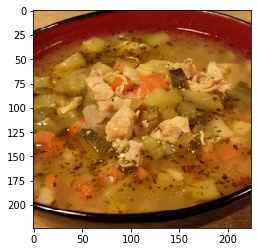

In [78]:
show(val_dataset, 45)

In [79]:
val_dataset[45][0].split('\n')

['Easy Spicy Chicken Soup',
 'olive oil',
 'onion',
 'carrots',
 'celery',
 'parsnips',
 'jalapenos',
 'italian seasoning',
 'dried cilantro',
 'chicken stock',
 'chicken meat',
 'summer squash',
 'Chop and dice parsnips, carrots, celery, onion and jalapenos.',
 'Add them to a pot with olive oil.',
 'Add seasoning and saute until half cooked.',
 'While the vegetables are cooking chop and dice, the chicken and Summer squash.',
 'Add 6 cups of stock, the Summer squash and chicken.',
 'If you need more broth add what you need.',
 'Heat until hot.']

In [236]:
i = 14
j = 14

In [237]:
val_dataset[i][0]

'Tagliatelle With Garlic, Gorgonzola and Basil\ntagliatelle pasta noodles\nbutter\ngarlic cloves\ngorgonzola\nlight cream\nfresh basil\nsalt\npepper\nBring a large saucepan of salted water to a boil.\nAdd the pasta and boil for 10-12 minutes until al dente.\nWhile the Pasta is cooking, melt the butter in a pan.\nAdd the garlic and cook for two minutes.\nAdd half the gorgonzola cheese to the pan with the cream and stir over low heat until the cheese has melted.\nAdd the basil and season with pepper, if needed.\nDrain the pasta, divide between warmed serving plates, pour the sauce over the pasta and scatter the remaining Gorgonzola cheese evenly over each dish.\nServe immediately.'

In [238]:
text_inputs = tokenizer(' '.join(val_dataset[i][0].split('\n')), truncation=True, padding=True, return_tensors="pt").to(device)
text_outputs = text_encoder(**text_inputs)
image_outputs = image_encoder(val_dataset[j][1].unsqueeze(0).to(device))
attention_mask = text_inputs.attention_mask

In [239]:
attention_mask.shape

torch.Size([1, 156])

In [240]:
i_f = image_outputs.to(device)
t_f = text_outputs.to(device)
a_m = ~attention_mask.bool().to(device)

t_input, mask = generate_transformer_input(i_f, t_f, a_m, cm_transformer)

In [241]:
image_outputs.shape

torch.Size([1, 197, 768])

In [242]:
mask.shape

torch.Size([1, 355])

In [243]:
_, attention = extract_selfattention_maps(cm_transformer.encoder, t_input.clone(), mask.clone())

In [244]:
tokenizer.convert_ids_to_tokens(text_inputs.input_ids.tolist()[0])

['[CLS]',
 'tag',
 '##lia',
 '##tell',
 '##e',
 'with',
 'garlic',
 ',',
 'go',
 '##rgo',
 '##nzo',
 '##la',
 'and',
 'basil',
 'tag',
 '##lia',
 '##tell',
 '##e',
 'pasta',
 'noodles',
 'butter',
 'garlic',
 'cl',
 '##ove',
 '##s',
 'go',
 '##rgo',
 '##nzo',
 '##la',
 'light',
 'cream',
 'fresh',
 'basil',
 'salt',
 'pepper',
 'bring',
 'a',
 'large',
 'sauce',
 '##pan',
 'of',
 'salt',
 '##ed',
 'water',
 'to',
 'a',
 'boil',
 '.',
 'add',
 'the',
 'pasta',
 'and',
 'boil',
 'for',
 '10',
 '-',
 '12',
 'minutes',
 'until',
 'al',
 'dent',
 '##e',
 '.',
 'while',
 'the',
 'pasta',
 'is',
 'cooking',
 ',',
 'melt',
 'the',
 'butter',
 'in',
 'a',
 'pan',
 '.',
 'add',
 'the',
 'garlic',
 'and',
 'cook',
 'for',
 'two',
 'minutes',
 '.',
 'add',
 'half',
 'the',
 'go',
 '##rgo',
 '##nzo',
 '##la',
 'cheese',
 'to',
 'the',
 'pan',
 'with',
 'the',
 'cream',
 'and',
 'stir',
 'over',
 'low',
 'heat',
 'until',
 'the',
 'cheese',
 'has',
 'melted',
 '.',
 'add',
 'the',
 'basil',
 'and',


In [245]:
tokenizer.convert_ids_to_tokens(text_inputs.input_ids.tolist()[0])[204-199]

'with'

In [246]:
attention[0][0][0][204].argmax()

tensor(305, device='cuda:0')

In [247]:
attention[0].shape

torch.Size([1, 2, 355, 355])

In [248]:
text_token_num = 240

In [249]:
attention[0][0][1][text_token_num]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [250]:
highest_attended = attention[0][0][1][text_token_num].argsort().tolist()[::-1][:10]
highest_attended

[202, 241, 319, 271, 318, 316, 317, 313, 312, 314]

In [251]:
attention[0][0][1][text_token_num][highest_attended]

tensor([1.0000e+00, 4.6976e-38, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00], device='cuda:0')

In [252]:
image_attentions = attention[1][0][1][text_token_num][1:198]
text_attentions = attention[1][0][1][text_token_num][199:]
image_attentions.shape, text_attentions.shape

(torch.Size([197]), torch.Size([156]))

In [253]:
patch_attentions = image_attentions[1:]
patch_attentions.shape

torch.Size([196])

In [254]:
temp = patch_attentions.view(224 // 16, -1)
temp.shape

torch.Size([14, 14])

In [255]:
patch_attentions

tensor([0.0014, 0.0021, 0.0020, 0.0016, 0.0022, 0.0014, 0.0023, 0.0020, 0.0017,
        0.0012, 0.0015, 0.0015, 0.0018, 0.0020, 0.0023, 0.0021, 0.0020, 0.0024,
        0.0013, 0.0017, 0.0017, 0.0018, 0.0023, 0.0015, 0.0019, 0.0019, 0.0019,
        0.0011, 0.0019, 0.0017, 0.0019, 0.0017, 0.0024, 0.0016, 0.0019, 0.0019,
        0.0019, 0.0020, 0.0019, 0.0020, 0.0019, 0.0016, 0.0019, 0.0021, 0.0021,
        0.0016, 0.0025, 0.0022, 0.0018, 0.0024, 0.0021, 0.0023, 0.0031, 0.0026,
        0.0012, 0.0020, 0.0018, 0.0021, 0.0016, 0.0023, 0.0012, 0.0014, 0.0015,
        0.0016, 0.0019, 0.0024, 0.0023, 0.0020, 0.0016, 0.0016, 0.0017, 0.0020,
        0.0019, 0.0021, 0.0010, 0.0016, 0.0029, 0.0014, 0.0017, 0.0018, 0.0021,
        0.0015, 0.0028, 0.0024, 0.0017, 0.0020, 0.0014, 0.0016, 0.0014, 0.0017,
        0.0011, 0.0013, 0.0020, 0.0019, 0.0018, 0.0016, 0.0012, 0.0031, 0.0018,
        0.0028, 0.0021, 0.0017, 0.0017, 0.0013, 0.0019, 0.0020, 0.0013, 0.0012,
        0.0019, 0.0018, 0.0015, 0.0017, 

In [256]:
from matplotlib import pyplot as plt

In [257]:
temp.cpu().numpy() / temp.max().item()

array([[0.40329045, 0.6202223 , 0.58062804, 0.46204484, 0.65862405,
        0.42264116, 0.6767762 , 0.59010905, 0.51264   , 0.3491813 ,
        0.43966594, 0.46053612, 0.5292424 , 0.5823798 ],
       [0.68215203, 0.6127631 , 0.6061911 , 0.7112489 , 0.38332438,
        0.49969175, 0.50628424, 0.52308226, 0.69322157, 0.43873635,
        0.56695276, 0.55443853, 0.5601848 , 0.33355948],
       [0.56742066, 0.5196323 , 0.5709034 , 0.51474154, 0.7076075 ,
        0.48951674, 0.57226944, 0.55993015, 0.5765476 , 0.58750373,
        0.55235934, 0.60544163, 0.5709051 , 0.46836326],
       [0.57899755, 0.6227494 , 0.6339251 , 0.46664464, 0.74028915,
        0.6617489 , 0.5312529 , 0.7167146 , 0.62917614, 0.689623  ,
        0.9117084 , 0.7782271 , 0.3588411 , 0.5818382 ],
       [0.5214402 , 0.62835896, 0.46257678, 0.6966145 , 0.35894755,
        0.4032756 , 0.4511874 , 0.46490338, 0.57525545, 0.72073156,
        0.6777099 , 0.58816546, 0.4671429 , 0.4657879 ],
       [0.49765837, 0.60819095, 0.5

In [258]:
num = 1
fig_name = f'img{num}.png'

Tagliatelle With Garlic, Gorgonzola and Basil


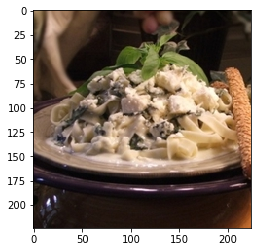

In [259]:
show(val_dataset, i, save=True, name=fig_name)

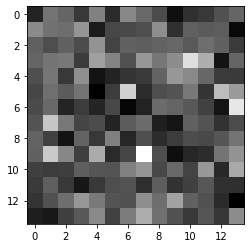

In [260]:
plt.imshow(temp.cpu().numpy() / temp.max().item(), cmap='gray')
plt.savefig(f'attention_map{num}.png')